# Loading and Cleaning Data

### Cleaning diabetic_data.csv

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib visualisation style
plt.style.use('seaborn-v0_8-pastel')

In [2]:
# Load data from csv
diabetic_df = pd.read_csv('../data/diabetic_data.csv')

# Replacing missing values identified by '?' with nan
diabetic_df_clean = diabetic_df.replace('?', np.nan)

# Adding new column showing if patient was readmitted within 30 days (high-risk patients)
diabetic_df_clean['readmitted_binary'] = np.where(diabetic_df_clean['readmitted'] == '<30', 1, 0)

# Replacing `AfricanAmerican` with `African American` in race column
diabetic_df_clean['race'] = diabetic_df_clean['race'].replace('AfricanAmerican', 'African American')

# Creating csv of cleaned diabetic data
diabetic_df_clean.to_csv('../data/cleaned_diabetic_data.csv', index=False)

### Creating Separate csv Files from IDS_mapping.csv

In [3]:
# Processing `IDS_mapping.csv`
from io import StringIO

# Read file
with open('../data/IDS_mapping.csv', encoding='utf-8') as f:
    content = f.read()

# Split file into sections by blank lines
sections = [s.strip() for s in content.strip().split('\n,\n')]
sections

test_df = pd.read_csv(StringIO(sections[0]))

IDS_mapping_list = []
for section in sections:
    df = pd.read_csv(StringIO(section))
    IDS_mapping_list.append(df)

# Create names for each dataframe in list - these are the names to save csv files as
IDS_mapping_names = [
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id'
]

# Looping through each dataframe and associated name and saving as separate csv files
for name, df in zip(IDS_mapping_names, IDS_mapping_list):
    df.to_csv(f'../data/{name}.csv', index=False)
    print(f'Saved: {name}.csv')

Saved: admission_type_id.csv
Saved: discharge_disposition_id.csv
Saved: admission_source_id.csv


# Readmission Overview

In [4]:
diabetic_df_clean

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,NO,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,0
2,64410,86047875,African American,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,Yes,NO,0
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,NO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,African American,Male,[70-80),NaN,1,3,7,3,...,Down,No,No,No,No,No,Ch,Yes,>30,0
101762,443847782,74694222,African American,Female,[80-90),NaN,1,4,5,5,...,Steady,No,No,No,No,No,No,Yes,NO,0
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,Down,No,No,No,No,No,Ch,Yes,NO,0
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,Up,No,No,No,No,No,Ch,Yes,NO,0


readmitted_binary
0    90409
1    11357
Name: count, dtype: int64


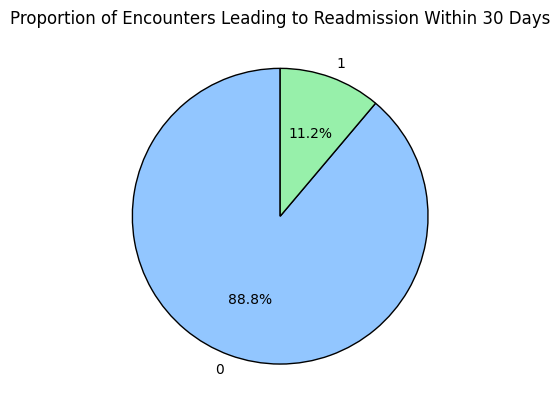

In [5]:
readmission_counts = diabetic_df_clean['readmitted_binary'].value_counts(dropna=False)
print(readmission_counts)

# Pie Chart
plt.pie(
    x=readmission_counts.values,
    labels=readmission_counts.index,
    startangle=90,
    autopct='%1.1f%%',
    wedgeprops={'edgecolor':'black'}
)
plt.title('Proportion of Encounters Leading to Readmission Within 30 Days')
plt.show()

Across all encounters, 11.2% (11,357 / 101,766) of these encounters were followed by a readmission of the patient within 30 days.

# Readmission by Patient Demographics

## Race

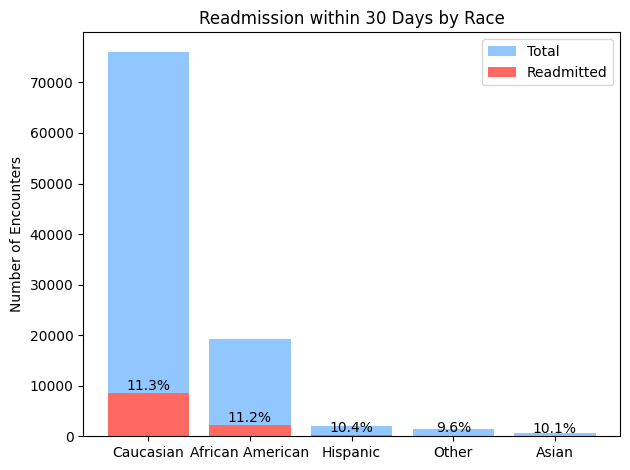

In [6]:
race_readmission = diabetic_df_clean[['race', 'readmitted_binary']]

# Total count of encounters and count of encounters with readmission within 30 days
total_by_race = race_readmission.groupby('race').size().rename('total')
race_readmission_count = race_readmission[race_readmission['readmitted_binary'] == 1].groupby('race').size().rename('readmitted')

# Summary dataframe
race_summary = pd.concat([race_readmission_count, total_by_race], axis=1).sort_values(by='total', ascending=False)
race_summary['percent_readmitted'] = 100 * race_summary['readmitted'] / race_summary['total']

# Plotting total bars
tot_bar = plt.bar(
    x=race_summary.index,
    height=race_summary['total'],
    label='Total'
)
# Plotting readmitted bars
read_bar = plt.bar(
    x=race_summary.index,
    height=race_summary['readmitted'],
    label='Readmitted',
    color='#FF6961'
)

# Add percent labels for each bar
for bar, pct in zip(read_bar, race_summary['percent_readmitted']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50,
        f'{pct:.1f}%',
        ha='center',
        va='bottom'
    )

# Adding graph elements
plt.title('Readmission within 30 Days by Race')
plt.ylabel('Number of Encounters')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Provide information as table
race_summary.sort_values(by='percent_readmitted', ascending=False)

,readmitted,total,percent_readmitted
race,,,
Caucasian,8592,76099,11.290556
African American,2155,19210,11.218116
Hispanic,212,2037,10.407462
Asian,65,641,10.140406
Other,145,1506,9.628154


Readmission rates across the four different races and those classified as 'Other' show very little variation.

`Caucasian` patients had the highest readmission rate within 30 days of 11.3%.

The lowest readmission rate was 9.6% for patients classified as `Other`.

## Gender

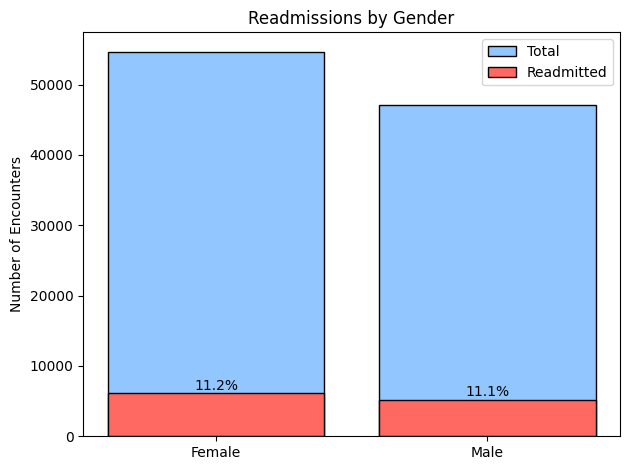

In [8]:
gender_readmission = diabetic_df_clean[['gender', 'readmitted_binary']]

# Drop rows where `gender` is 'Unknown/Invalid' as there are only 3 with this classification
gender_readmission = gender_readmission[gender_readmission['gender'] != 'Unknown/Invalid']

# Total and readmission within 30 days counts
readmission_by_gender = gender_readmission[gender_readmission['readmitted_binary'] == 1].groupby('gender').size().rename('readmitted')
total_by_gender = gender_readmission.groupby('gender').size().rename('total')

# Summary dataframe
gender_summary = pd.concat([readmission_by_gender, total_by_gender], axis=1)
gender_summary['percent_readmitted'] = 100 * gender_summary['readmitted'] / gender_summary['total']

# Plotting total bars
tot_bar = plt.bar(
    x=gender_summary.index,
    height=gender_summary['total'],
    label='Total',
    edgecolor='black'
)

# Plotting readmitted bars
read_bar = plt.bar(
    x=gender_summary.index,
    height=gender_summary['readmitted'],
    color='#FF6961',
    label='Readmitted',
    edgecolor='black'
)

# Adding percent readmitted labels
for bar, pct in zip(read_bar, gender_summary['percent_readmitted']):
    height=bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50,
        f'{pct:.1f}%',
        ha='center',
        va='bottom'
    )

plt.title('Readmissions by Gender')
plt.ylabel('Number of Encounters')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Provide information as table
gender_summary.sort_values(by='percent_readmitted', ascending=False)

,readmitted,total,percent_readmitted
gender,,,
Female,6152,54708,11.245156
Male,5205,47055,11.061524


Readmission rates are almost identical between female and male patients (11.2% and 11.1% respectively)

## Age

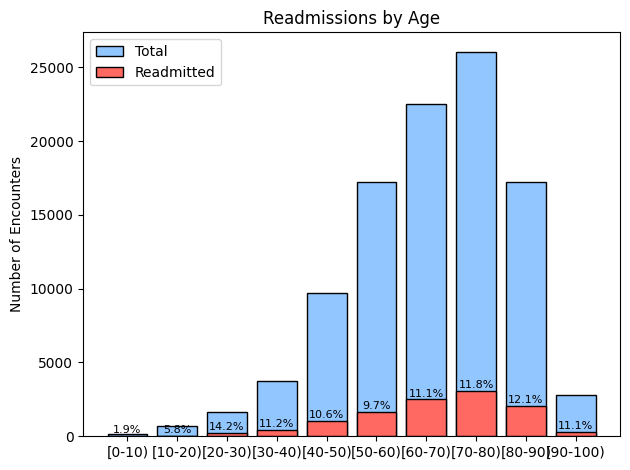

In [10]:
age_readmission = diabetic_df_clean[['age', 'readmitted_binary']]
age_readmission


# Total and readmission within 30 days counts
readmission_by_age = age_readmission[age_readmission['readmitted_binary'] == 1].groupby('age').size().rename('readmitted')
total_by_age = age_readmission.groupby('age').size().rename('total')

# Summary dataframe
age_summary = pd.concat([readmission_by_age, total_by_age], axis=1)
age_summary['percent_readmitted'] = 100 * age_summary['readmitted'] / age_summary['total']

# Plotting total bars
tot_bar = plt.bar(
    x=age_summary.index,
    height=age_summary['total'],
    label='Total',
    edgecolor='black'
)

# Plotting readmitted bars
read_bar = plt.bar(
    x=age_summary.index,
    height=age_summary['readmitted'],
    color='#FF6961',
    label='Readmitted',
    edgecolor='black'
)

# Adding percent readmitted labels
for bar, pct in zip(read_bar, age_summary['percent_readmitted']):
    height=bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50,
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.title('Readmissions by Age')
plt.ylabel('Number of Encounters')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Provide information as table
age_summary.sort_values(by='percent_readmitted', ascending=False)

,readmitted,total,percent_readmitted
age,,,
[20-30),236,1657,14.242607
[80-90),2078,17197,12.083503
[70-80),3069,26068,11.773055
[30-40),424,3775,11.231788
[60-70),2502,22483,11.128408
[90-100),310,2793,11.099177
[40-50),1027,9685,10.604027
[50-60),1668,17256,9.666203
[10-20),40,691,5.788712


Readmission rates differ significantly between different age brackets and show some interesting patterns.

Babies, children, and teenagers (age brackets `0-10` and `10-20`) show the lowest readmission rates (1.9% and 5.8% respectively). This could be due to diabetes encounters being less severe in these age groups, or patients in these age groups experiencing much better recoveries compared to older age groups.

Interestingly, young adults in the age bracket `20-30` have the highest readmission rate of 14.2%. This may be due to a diabetes diagnosis in young adults being associated with more severe illness, despite being much rarer than in older patients.

Alongside increasing number of encounters, there appears to be a decrease in readmission rates with increasing age between age brackets `20-30` through to `50-60`. Again, this suggests diabetes is more common with increasing age, but may be less severe and lower risk for older patients compared to younger patients up to a certain point.

Beyond the `50-60` age bracket, readmission rates increase with increasing age, up to 12.1% for patients aged `80-90`. This may be due to participants becoming more frail in their health beyond the age of 60.

The number of encounters where the patient was aged `80-90` and `90-100` show a decrease in frequency compared to the preceding age brackets. This might be due to higher mortality rates in these age groups, particularly for patients diagnosed with diabetes which is associated with lower life-expectancy.

There is a decrease in mortality rate for the oldest age bracket `90-100` (11.1%) compared to the second oldest age bracket `80-90` (12.1%). This could be due many different reasons. For example, patients in this age bracket may live in aged-care facilities where future issues are managed in-house rather than through readmission. Patients in this age bracket may also receive more conservative or community-based management of conditions compared to younger ages. Another potential explanation may be that this age group has a high mortality rate, which means mortality may occur before readmission can occur.

## Weight

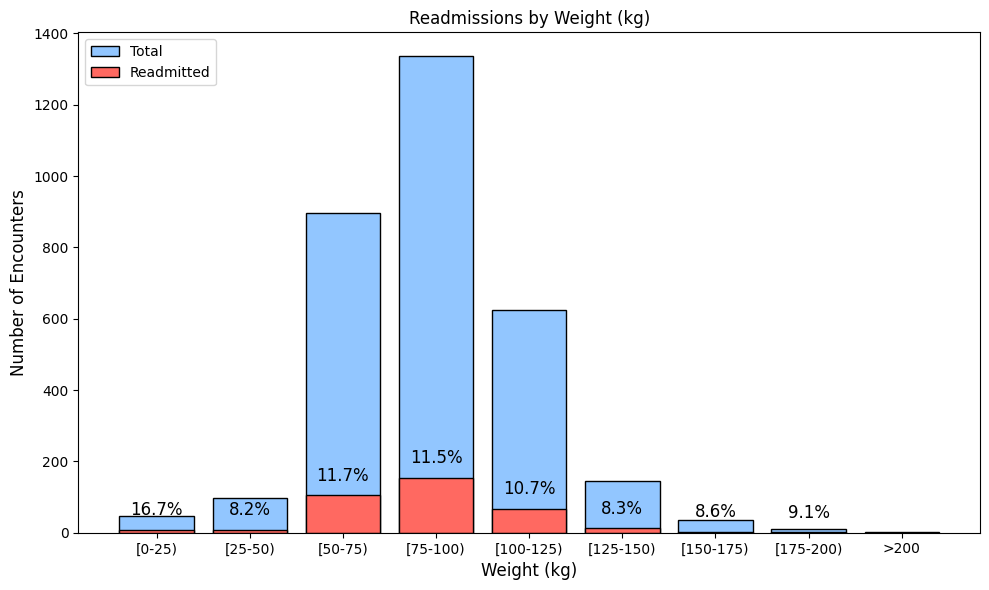

In [16]:
weight_readmission = diabetic_df_clean[['weight', 'readmitted_binary']]

# Total and readmission within 30 days counts
readmission_by_weight = weight_readmission[weight_readmission['readmitted_binary'] == 1].groupby('weight').size().rename('readmitted')
total_by_weight= weight_readmission.groupby('weight').size().rename('total')

# Summary dataframe
weight_summary = pd.concat([readmission_by_weight, total_by_weight], axis=1)
weight_summary['percent_readmitted'] = 100 * weight_summary['readmitted'] / weight_summary['total']

# Create function to extract lower bound of weight brackets for sorting these brackets
def extract_lower_bound(label):
    if label.startswith('['):
        return int(label[1:].split('-')[0])
    elif label.startswith('?'):
        return -1
    elif label.startswith('>'):
        return 9999
    else:
        return 0
    
# Sort age brackets in ascending order
sorted_index = sorted(weight_summary.index, key=extract_lower_bound)
weight_summary = weight_summary.reindex(index=sorted_index)

# Plotting total bars
plt.figure(figsize=(10,6))
tot_bar = plt.bar(
    x=weight_summary.index,
    height=weight_summary['total'],
    label='Total',
    edgecolor='black'
)

# Plotting readmitted bars
read_bar = plt.bar(
    x=weight_summary.index,
    height=weight_summary['readmitted'],
    color='#FF6961',
    label='Readmitted',
    edgecolor='black'
)

# Adding percent readmitted labels
for bar, pct in zip(read_bar, weight_summary['percent_readmitted']):
    height=bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 30,
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=12
    )


plt.title('Readmissions by Weight (kg)')
plt.ylabel('Number of Encounters', fontsize=12)
plt.xlabel('Weight (kg)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Provide information as table
weight_summary.sort_values(by='percent_readmitted', ascending=False)

,readmitted,total,percent_readmitted
weight,,,
[0-25),8.0,48,16.666667
[50-75),105.0,897,11.705686
[75-100),153.0,1336,11.452096
[100-125),67.0,625,10.720000
[175-200),1.0,11,9.090909
[150-175),3.0,35,8.571429
[125-150),12.0,145,8.275862
[25-50),8.0,97,8.247423
>200,NaN,3,NaN


Looking at the age brackets and their frequencies, it appears the data description which describes these weights as being in units of pounds (lbs) is likely incorrect. Most likely, these weights are in kilograms (kgs), as the frequencies align much better with typical body weight in kg. Therefore, the units will be assumed to be kg for this analysis.

Considering the lowest weight bracket `0-25`, it is possible that these contain many cases of inaccurate weight measurements, unless they are mostly made up of babies and young children.

Therefore, the ages of patients in this weight bracket is assessed below:

In [17]:
diabetic_df_clean[diabetic_df_clean['weight'] == '[0-25)']['age'].value_counts()

age
[70-80)    14
[60-70)    12
[40-50)     7
[80-90)     6
[50-60)     4
[0-10)      3
[30-40)     1
[20-30)     1
Name: count, dtype: int64

As shown, these patients within the `0-25` weight bracket are typically adults, with very few babies and young children. Therefore, patients in these categories are likely to have their weight recorded incorrectly.

It appears that patients of lower weight may have slightly higher readmission rates overall compared to patients of higher weight. This may be due to lower weight being associated with greater frailty and poorer health outcomes.

## Admission Type

In [134]:
# Function to create dataframe by merging main dataframe with description dataframe using id column
def merge_description(col):

    # Loading csv
    csv = pd.read_csv(f'../data/{col}.csv')

    # Joining id with description from csv
    merged_df = pd.merge(diabetic_df_clean[[f'{col}', 'readmitted_binary']], csv, on=f'{col}')[[f'{col}', 'description', 'readmitted_binary']]
    return merged_df


In [207]:
# Function to take column name and create bar plot showing total encounters and readmitted encounters
def plot_col(col, vertical_barplot=True, xtick_rot=0, xtick_fontsize=10, ytickfontsize=10):

    # filtered_df = diabetic_df_clean[[f'{col}', 'readmitted_binary']]
    filtered_df = merge_description(col)

    # Total and readmission within 30 days counts
    readmission_by_col = filtered_df[filtered_df['readmitted_binary'] == 1].groupby('description').size().rename('readmitted')
    total_by_col= filtered_df.groupby('description').size().rename('total')

    # Summary dataframe
    col_summary = pd.concat([readmission_by_col, total_by_col], axis=1)
    col_summary['percent_readmitted'] = 100 * col_summary['readmitted'] / col_summary['total']

    if vertical_barplot == True:

        col_summary = col_summary.sort_values(by='total', ascending=False)

        # Plotting total bars
        plt.figure(figsize=(10,6))
        tot_bar = plt.bar(
            x=col_summary.index,
            height=col_summary['total'],
            label='Total',
            edgecolor='black'
        )

        # Plotting readmitted bars
        read_bar = plt.bar(
            x=col_summary.index,
            height=col_summary['readmitted'],
            color='#FF6961',
            label='Readmitted',
            edgecolor='black'
        )

        # Adding percent readmitted labels
        for bar, pct in zip(read_bar, col_summary['percent_readmitted']):
            height=bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 30,
                f'{pct:.1f}%',
                ha='center',
                va='bottom',
                fontsize=10
            )

        plt.title(f'Readmissions by {col}', fontsize=14)
        plt.xlabel('', fontsize=12)
        plt.xticks(rotation=xtick_rot, fontsize=xtick_fontsize)
        plt.ylabel('Number of Encounters', fontsize=12)
        plt.yticks(fontsize=ytickfontsize)
        plt.legend(fontsize=12, loc='upper right')
        plt.tight_layout()
        plt.show()

    else:

        col_summary = col_summary.sort_values(by='total', ascending=True)

        # Plotting total bars
        plt.figure(figsize=(10,6))
        tot_bar = plt.barh(
            y=col_summary.index,
            width=col_summary['total'],
            label='Total',
            edgecolor='black'
        )

        # Plotting readmitted bars
        read_bar = plt.barh(
            y=col_summary.index,
            width=col_summary['readmitted'],
            color='#FF6961',
            label='Readmitted',
            edgecolor='black'
        )

        # Adding percent readmitted labels
        for bar, pct in zip(read_bar, col_summary['percent_readmitted']):
            width=bar.get_width()
            plt.text(
                width + 1,
                bar.get_y() + bar.get_height() / 2,
                f'{pct:.1f}%',
                ha='left',
                va='center',
                fontsize=10
            )

        plt.title(f'Readmissions by {col}', fontsize=14)
        plt.xlabel('', fontsize=12)
        plt.xticks(rotation=xtick_rot, fontsize=xtick_fontsize)
        plt.ylabel('Number of Encounters', fontsize=12)
        plt.yticks(fontsize=ytickfontsize)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

    # Printing summary dataframe ordered by readmission rate
    print(col_summary.sort_values(by='percent_readmitted', ascending=False))

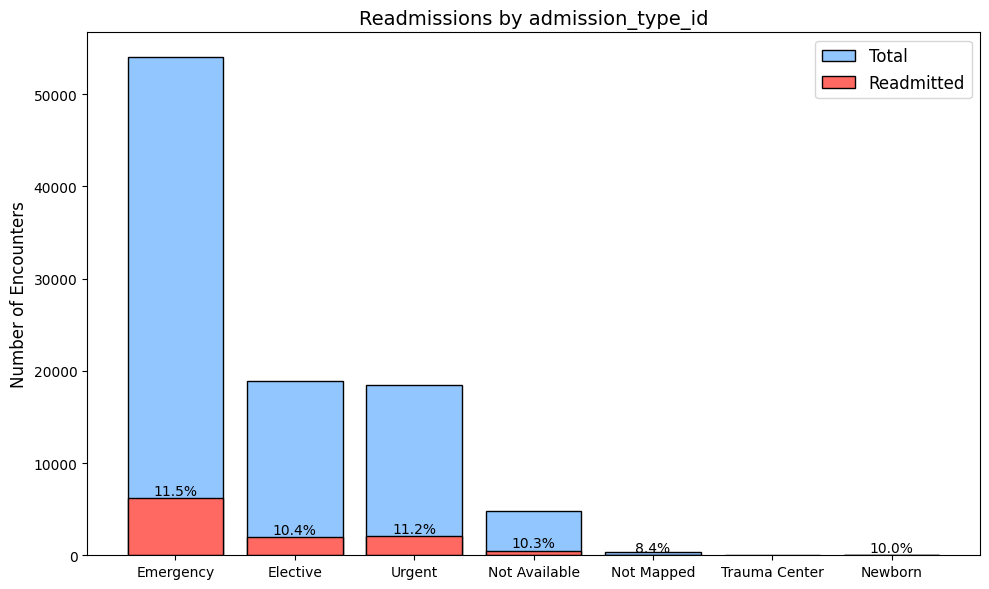

               readmitted  total  percent_readmitted
description                                         
Emergency          6221.0  53990           11.522504
Urgent             2066.0  18480           11.179654
Elective           1961.0  18869           10.392708
Not Available       495.0   4785           10.344828
Newborn               1.0     10           10.000000
Not Mapped           27.0    320            8.437500
Trauma Center         NaN     21                 NaN


In [204]:
# Using custom plotting function to create `Admission Type` readmitted vs total bar plot and table
plot_col('admission_type_id')

Emergency admissions form a significant majority of encounters. Elective and Urgent admissions are the next most common admission types, with similar frequencies to each other. Other Admission types are much less frequent.

Readmission rates do not appear to differ significantly between admission types.

## Admission Source

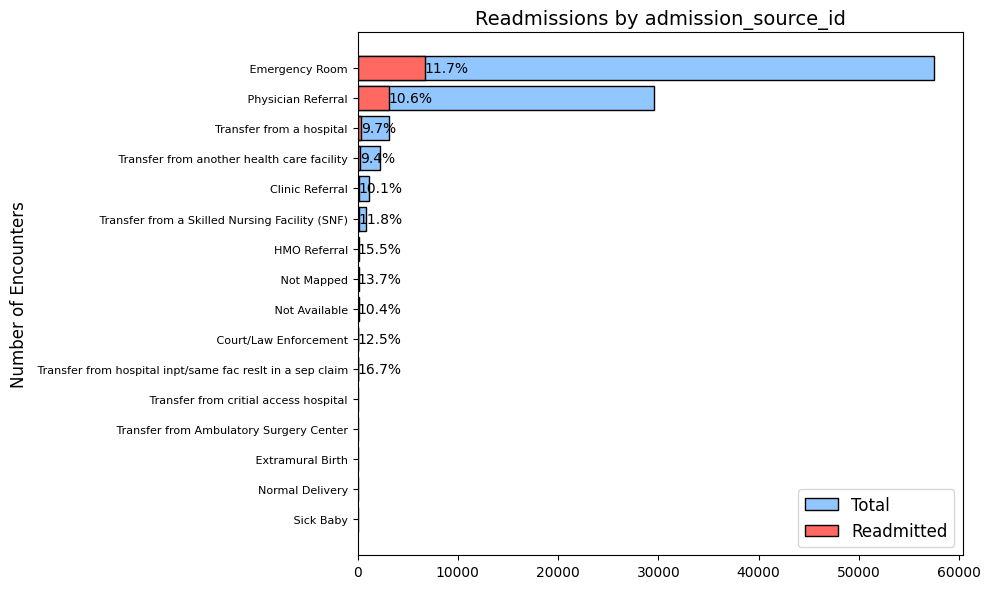

                                                    readmitted  total  \
description                                                             
 Transfer from hospital inpt/same fac reslt in ...         2.0     12   
HMO Referral                                              29.0    187   
 Not Mapped                                               22.0    161   
 Court/Law Enforcement                                     2.0     16   
 Transfer from a Skilled Nursing Facility (SNF)          101.0    855   
 Emergency Room                                         6720.0  57494   
 Physician Referral                                     3130.0  29565   
 Not Available                                            13.0    125   
Clinic Referral                                          111.0   1104   
Transfer from a hospital                                 309.0   3187   
 Transfer from another health care facility              212.0   2264   
 Sick Baby                                         

In [208]:
# Using custom plotting function to create `Admission Source` readmitted vs total bar plot and table
plot_col('admission_source_id', vertical_barplot=False, ytickfontsize=8)